<a href="https://colab.research.google.com/github/Doppler-67/telecom-users-churn-forecasting/blob/main/telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Telecom project**



# **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sqlalchemy import create_engine

In [2]:
sns.set()

# **Data understanding**

Подключимся к базе данных.

In [3]:
db_config = {
'user': '**********', 
'pwd' : '*******', 
'host': '**************************',
'port': '****', 
'db'  : 'telecom' 
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

In [6]:
query = '''
SELECT *
FROM telecom.contract  
'''

contracts = pd.read_sql_query(query, con=engine) 

In [7]:
query = '''
SELECT *
FROM telecom.personal   
'''

clients = pd.read_sql_query(query, con=engine) 

In [8]:
query = '''
SELECT *
FROM telecom.internet  
'''

internet = pd.read_sql_query(query, con=engine) 

In [9]:
query = '''
SELECT *
FROM telecom.phone   
'''

telephony = pd.read_sql_query(query, con=engine) 

Изучим данные.

In [10]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [11]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [12]:
contracts.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


----------------

In [13]:
clients.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
clients['customerID'].duplicated().sum()

0

In [15]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
clients.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


------------------

In [17]:
internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [19]:
internet.describe()

,c1,c2,c3,c4,c5,c6,c7,c8
count,5518,5518,5518,5518,5518,5518,5518,5518
unique,5518,3,3,3,3,3,3,3
top,customerID,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------

In [20]:
telephony.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [21]:
telephony.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
telephony.describe()

,c1,c2
count,6362,6362
unique,6362,3
top,customerID,No
freq,1,3390


У всех таблиц есть общий ключ - customerID. В таблицах internet и telephony названия столбцов находится в 0 строке, а вместо нормальных названий колонок стоят непонятные с1, c2 и тд. В остальном все нормально. Приступим к предобработке.

# **Data preparation & EDA**

Для начала исправим названия колонок в таблицах internet и telephony.

In [23]:
internet.columns = list(internet.iloc[0, :])
internet = internet.drop(0, axis=0).reset_index(drop=True)

In [24]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
telephony.columns = list(telephony.iloc[0, :])
telephony = telephony.drop(0, axis=0).reset_index(drop=True)

In [26]:
telephony.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Теперь во всех таблицах приведем названия колонок к змеиному регистру и изменим заглавные символы.

In [27]:
internet_cols = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
contracts_cols = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
clients_cols = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
telephony_cols = ['customer_id', 'multiple_lines']

In [28]:
internet.columns = internet_cols
contracts.columns = contracts_cols
clients.columns = clients_cols
telephony.columns = telephony_cols

Теперь соеденим таблицы в один датафрейм.

Так как нам в первую очередь важны уникальные пользователи то будем мерджить c помощью left join к таблице clients.

In [29]:
df1 = pd.merge(clients, contracts, on='customer_id', how='left')
df2 = pd.merge(df1, telephony, on='customer_id', how='left')
data = pd.merge(df2, internet, on='customer_id', how='left')

Так как в итоговой таблице содержутся только уникальные пользователи - дропнем customer_id, он нам больше не понадобится.

In [30]:
data = data.drop('customer_id', axis=1)

In [31]:
data.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No
2,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   begin_date         7043 non-null   object 
 5   end_date           1869 non-null   object 
 6   type               7043 non-null   object 
 7   paperless_billing  7043 non-null   object 
 8   payment_method     7043 non-null   object 
 9   monthly_charges    7043 non-null   float64
 10  total_charges      7032 non-null   float64
 11  multiple_lines     6361 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Приведем к нужному типа колонки begin_date и end_data.

In [33]:
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']].apply(pd.to_datetime)

Изучим колонку gender.

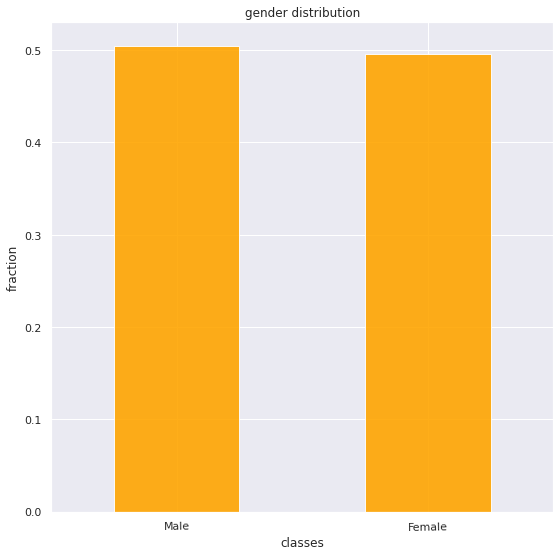

In [34]:
data['gender'].value_counts(normalize=True).plot(kind='bar', title='gender distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

В колонке gender классы сбалансированы.

Изучим колонку senior_citizen.

In [35]:
data['senior_citizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64

In [36]:
data['senior_citizen'] = data['senior_citizen'].astype(bool)

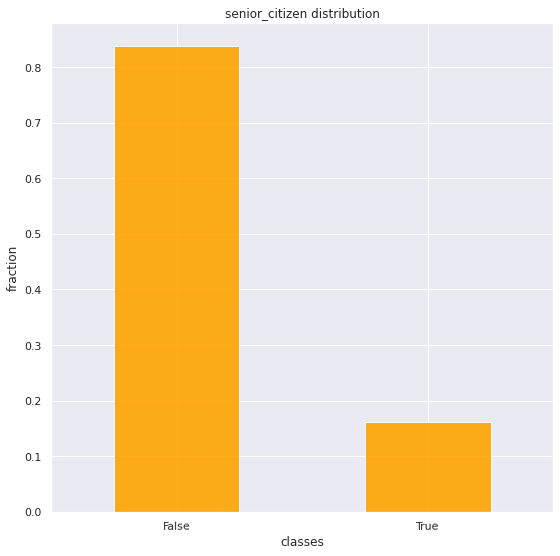

In [37]:
data['senior_citizen'].value_counts(normalize=True).plot(kind='bar', title='senior_citizen distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

Более 80% клиентов не являются пенсионерами.

Изучи колонку partner.

In [38]:
data['partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

In [39]:
data['partner'] = data['partner'].apply(lambda x: True if x == 'Yes' else False)

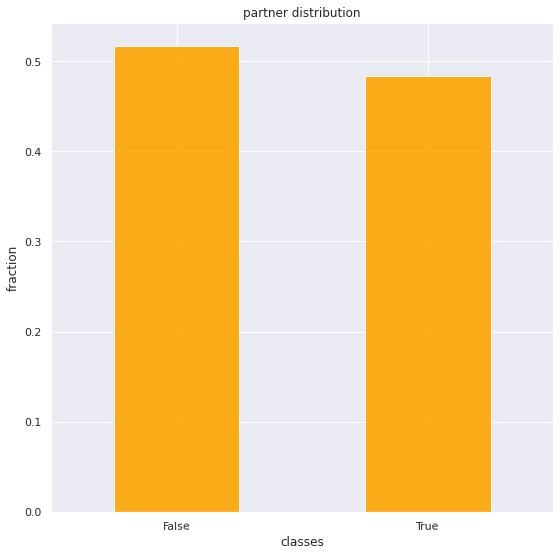

In [40]:
data['partner'].value_counts(normalize=True).plot(kind='bar', title='partner distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

Половина клиентов жената.

Изучим колонку dependents.

In [41]:
data['dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

In [42]:
data['dependents'] = data['dependents'].apply(lambda x: True if x == 'Yes' else False)

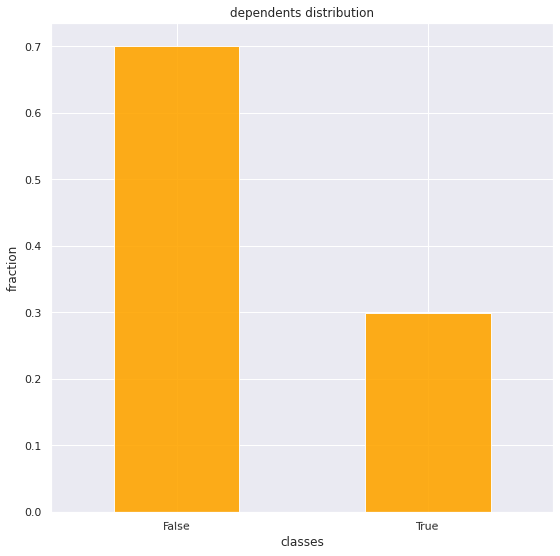

In [43]:
data['dependents'].value_counts(normalize=True).plot(kind='bar', title='dependents distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

У 70% пользователей нет детей.

Изучим колонку type.

In [44]:
data['type'].value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64

In [45]:
def edit_type(s):
  if s == 'Month-to-month':
    return 'monthly'
  elif s == 'One year':
    return 'every year'
  else:
    return 'every two years'

In [46]:
data['type'] = data['type'].apply(edit_type)

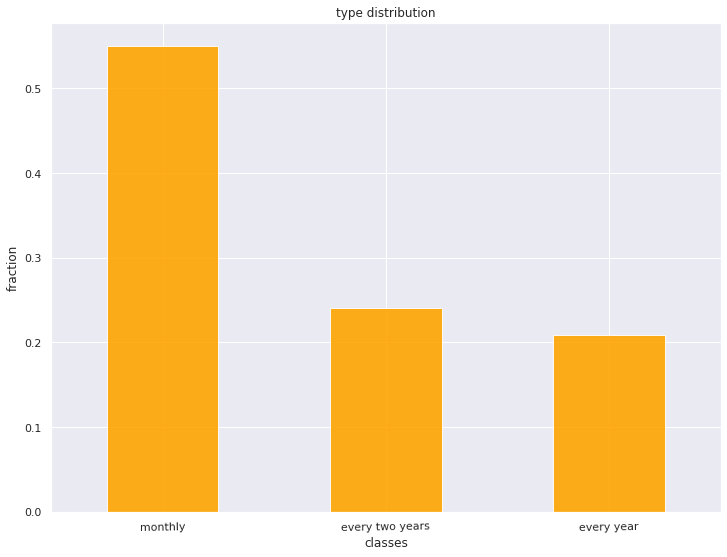

In [47]:
data['type'].value_counts(normalize=True).plot(kind='bar', title='type distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Половина клиентов платит ежемесячно. Четверть клиентов платит раз в год. Оставшаяся часть клиентов платит раз в два года.

Изучим колонку paperless_billing.

In [48]:
data['paperless_billing'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64

In [49]:
data['paperless_billing'] = data['paperless_billing'].apply(lambda x: True if x == 'Yes' else False)

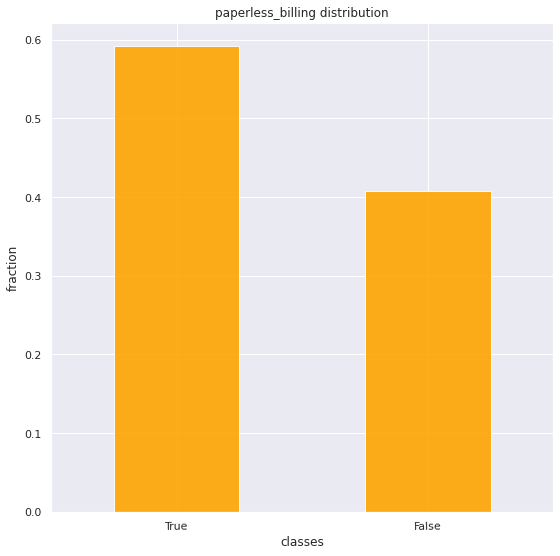

In [50]:
data['paperless_billing'].value_counts(normalize=True).plot(kind='bar', title='paperless_billing distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

60% клинетов оплачивают услуги онлайн.

Изучим колонку payment_method.

In [51]:
data['payment_method'].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

In [52]:
def edit_payment(s):
  if s == 'Electronic check':
    return 'electronic check'
  elif s == 'Mailed check':
    return 'mailed check'
  elif s == 'Bank transfer (automatic)':
    return 'bank transfer'
  else:
    return 'credit card'

In [53]:
data['payment_method'] = data['payment_method'].apply(edit_payment)

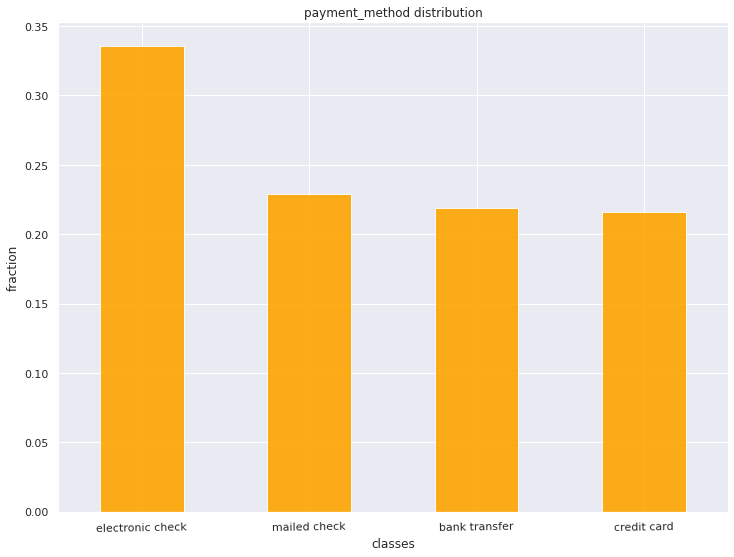

In [54]:
data['payment_method'].value_counts(normalize=True).plot(kind='bar', title='payment_method distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Пользоватли используют четыре типа платежа для оплаты услуг:
1. Электронный чек.
2. чек, отправленный по почте.
3. банковский перевод.
4. кредитной картой.

Больше всего пользователей используют электронный чек.

Изучим колонку monthly_charges.

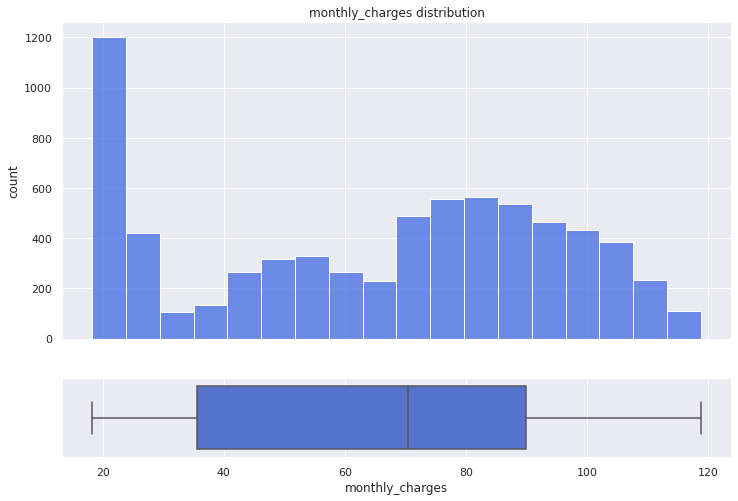

In [55]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['monthly_charges'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['monthly_charges'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='monthly_charges')
ax_hist.set(ylabel='count')
ax_hist.set(title='monthly_charges distribution')
plt.show()

Изучим колонку total_charges.

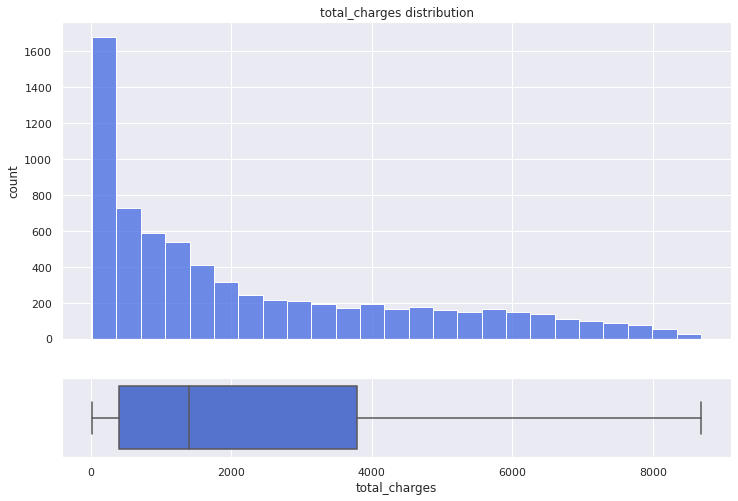

In [56]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['total_charges'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['total_charges'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='total_charges')
ax_hist.set(ylabel='count')
ax_hist.set(title='total_charges distribution')
plt.show()

Распределение экспоненциальное.


В этой колонке 11 пропусков. Это очень не существенно. Заполним их медианой.

In [57]:
data['total_charges'].isna().sum()

11

In [58]:
data['total_charges'] = data['total_charges'].fillna(data['total_charges'].median()) ###

Изучим колонку multiple_lines.

In [59]:
data['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Тут уже пропусков много. Присвом им значение 'none'.

In [60]:
data['multiple_lines'].isna().sum()

682

In [61]:
data['multiple_lines'] = data['multiple_lines'].fillna('none')

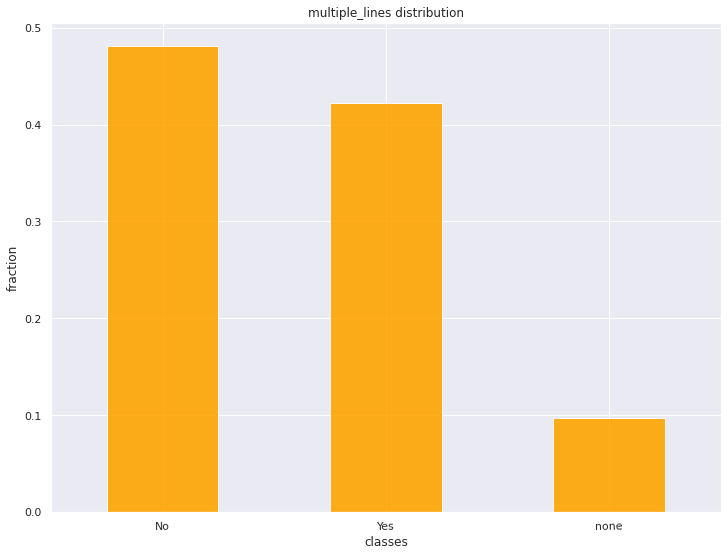

In [62]:
data['multiple_lines'].value_counts(normalize=True).plot(kind='bar', title='multiple_lines distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

-------------

В колонках из таблицы internet, присутствует много пропусков из-за того, что есть пользователи, которые не пользуются интернетом.

Всем пропускам в этих колонках присвом значение 'none'.

In [63]:
cols_with_na = ['internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [64]:
data[cols_with_na] = data[cols_with_na].fillna('none')

------------

Изучим колонку internet_service.

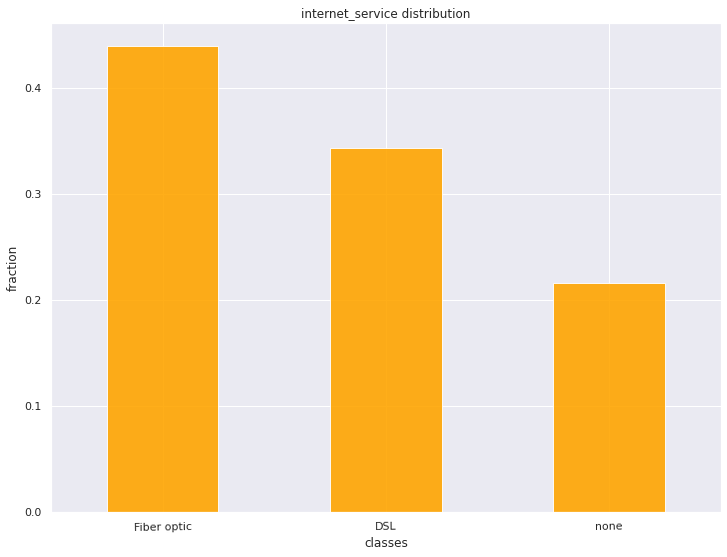

In [65]:
data['internet_service'].value_counts(normalize=True).plot(kind='bar', title='internet_service distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Более 40% пользователей подключены к интернету при помощи оптоволокна.

Изучим колонку online_security.

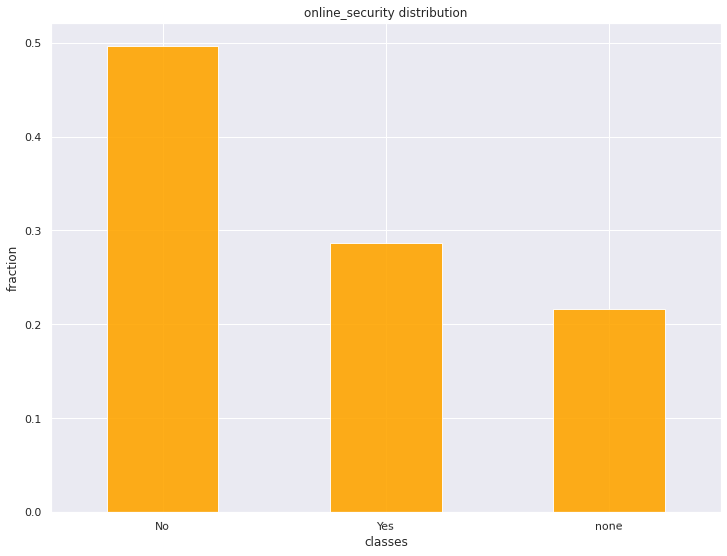

In [66]:
data['online_security'].value_counts(normalize=True).plot(kind='bar', title='online_security distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Половина пользователей не пользуется блокировкой небезопасных сайтов.

Изучим колонку online_backup.

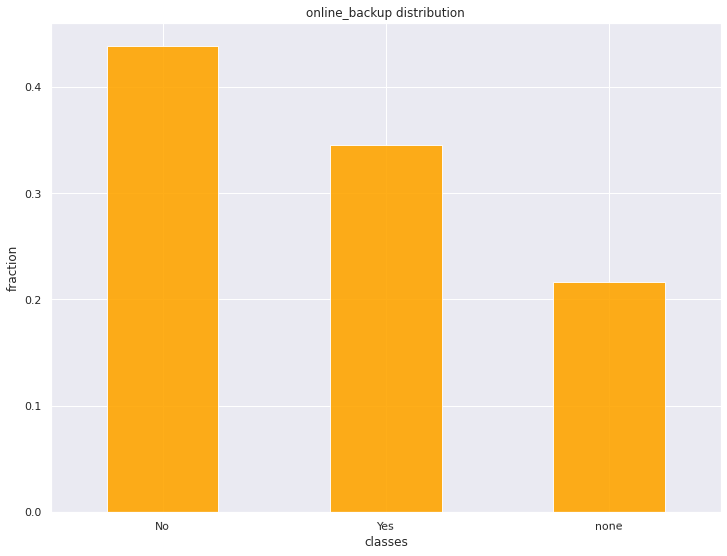

In [67]:
data['online_backup'].value_counts(normalize=True).plot(kind='bar', title='online_backup distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Более 40% пользователей не используют резервное копирование данных.

Изучим колонку device_protection.

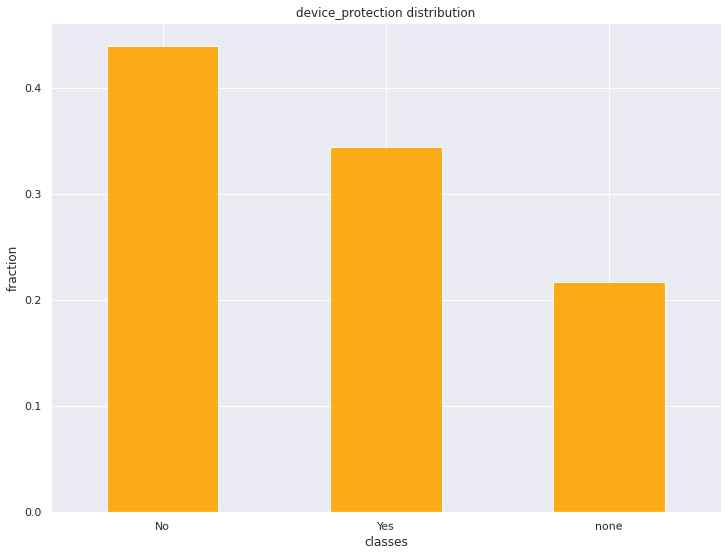

In [68]:
data['device_protection'].value_counts(normalize=True).plot(kind='bar', title='device_protection distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Более 40% пользователей не пользуются антивирусом.

Изучим колонку tech_support.

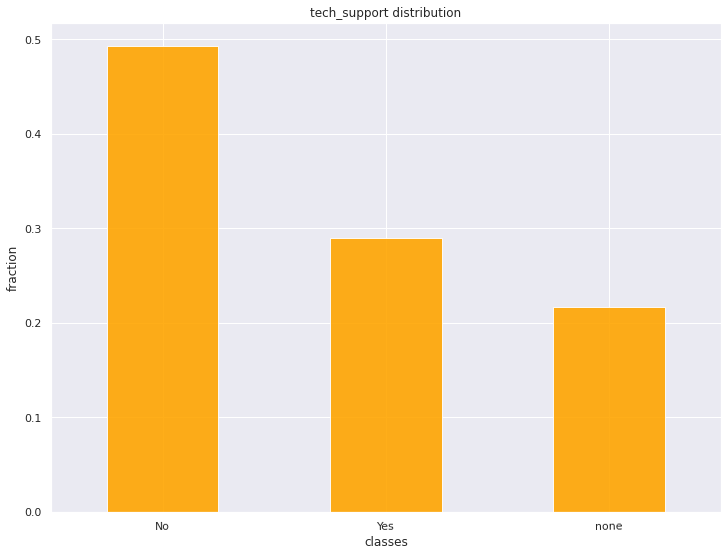

In [69]:
data['tech_support'].value_counts(normalize=True).plot(kind='bar', title='tech_support distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Почти половина людей имеют доступ к выделенной службе поддержки.

Изучим колонку streaming_tv.

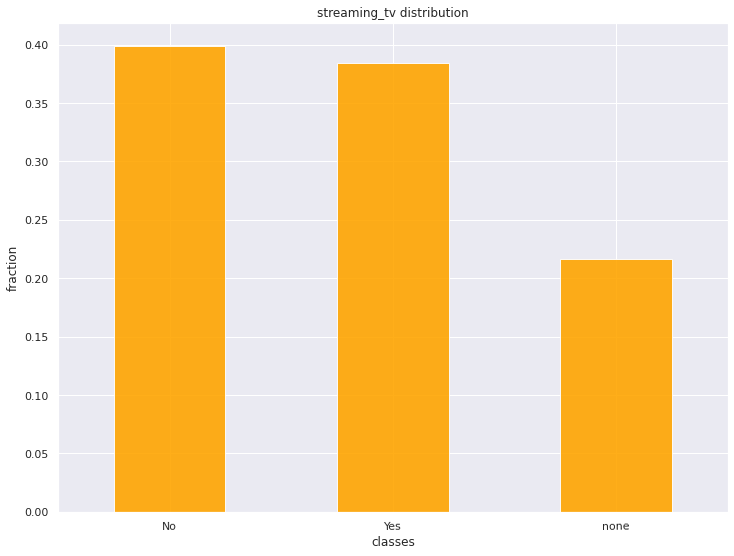

In [70]:
data['streaming_tv'].value_counts(normalize=True).plot(kind='bar', title='streaming_tv distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

40% пользователей не используют стриминговое телевидение.

Изучим колонку streaming_movies.

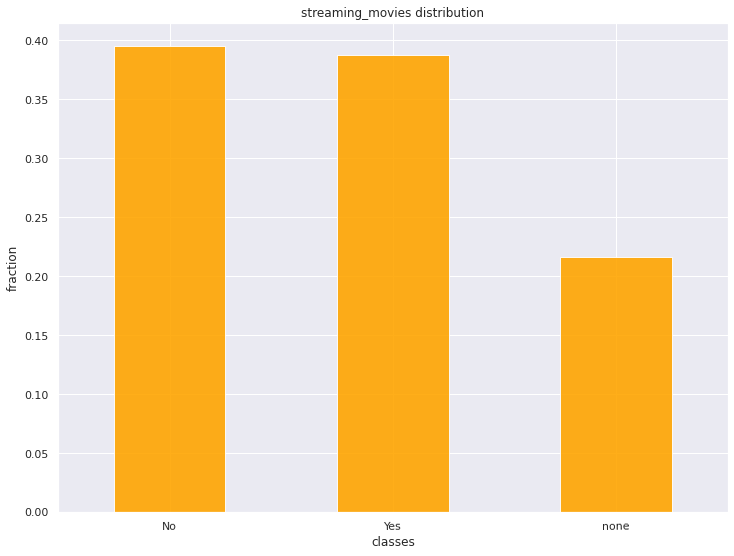

In [71]:
data['streaming_movies'].value_counts(normalize=True).plot(kind='bar', title='streaming_movies distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(12,9))
plt.show()

Почти 40% пользователей не имеют доступа к онлайн каталогу фильмов.

Изучим колонку begin_date

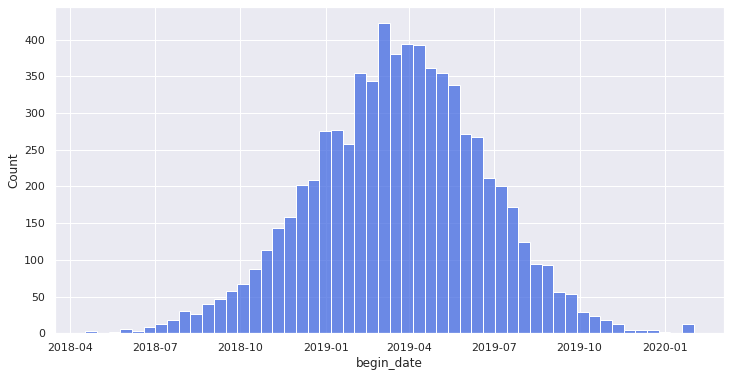

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(x=data['begin_date'], color='royalblue')
plt.show()

Распределение нормальное.

Больше всего пользователей пришло весной.

Изучим колонку end_date.

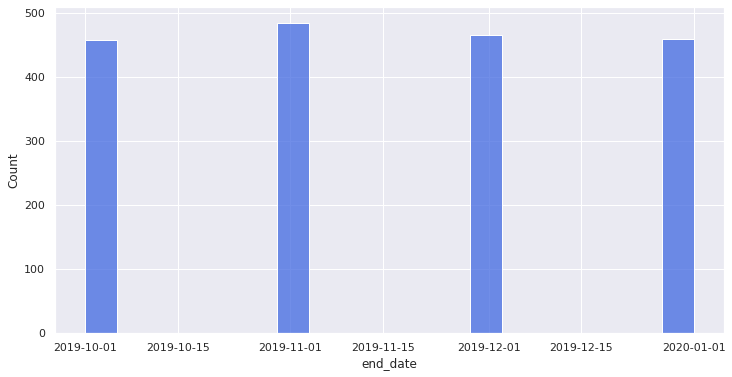

In [73]:
plt.figure(figsize=(12, 6))
sns.histplot(x=data['end_date'], color='royalblue')
plt.show()

В данной колонке очень много пропусков. Пропуски говорят о том, что пользователи не ушли в отток.

Создадим таргет.

In [74]:
data['is_active'] = data['end_date'].apply(lambda x: True if pd.isna(x) else False)

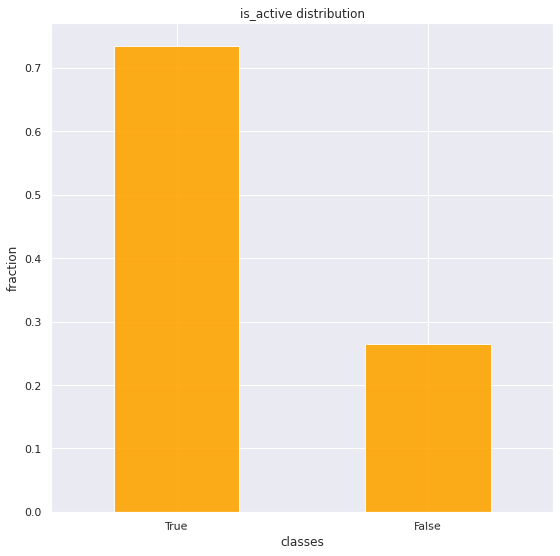

In [75]:
data['is_active'].value_counts(normalize=True).plot(kind='bar', title='is_active distribution', xlabel='classes', 
                                     ylabel='fraction', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

Как мы видим всего примерно 25% людей, ушедших в отток.

Присутствует дисбаланс классов.

Посмотрим на распределение времени пользования у пользователей, которые ушли в отток.

In [76]:
delta = (data[data['is_active'] == False]['end_date'] - data[data['is_active'] == False]['begin_date']).dt.days

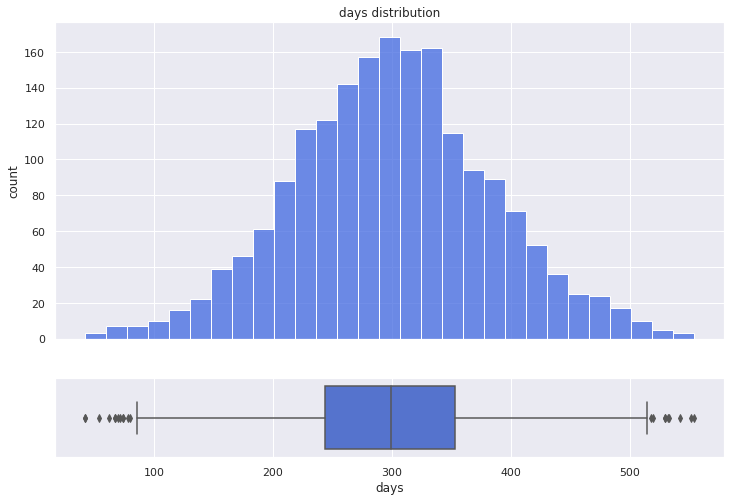

In [77]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=delta, ax=ax_hist, color='royalblue')
sns.boxplot(x=delta, ax=ax_box, color='royalblue')

ax_box.set(xlabel='days')
ax_hist.set(ylabel='count')
ax_hist.set(title='days distribution')
plt.show()

In [78]:
delta.describe()

count    1869.000000
mean      299.982879
std        84.423849
min        42.000000
25%       244.000000
50%       299.000000
75%       353.000000
max       554.000000
dtype: float64

Распределение нормальное.

Пользователи которые ушли в отток пробыли клиентами компании в среднем 300 дней.

Удалим ненужные колонки.

In [79]:
data = data.drop(['begin_date', 'end_date'], axis=1)

In [80]:
data.head()

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_active
0,Female,False,True,False,monthly,True,electronic check,29.85,29.85,none,DSL,No,Yes,No,No,No,No,True
1,Male,False,False,False,every year,False,mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No,True
2,Male,False,False,False,monthly,True,mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,False
3,Male,False,False,False,every year,False,bank transfer,42.30,1840.75,none,DSL,Yes,No,Yes,Yes,No,No,True
4,Female,False,False,False,monthly,True,electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,False


Теперь сравним распределения величин ежемесячных платежей активных клиентов и тех, кто ушёл.

In [81]:
active = data[data['is_active']]
not_active =  data[data['is_active'] == False]

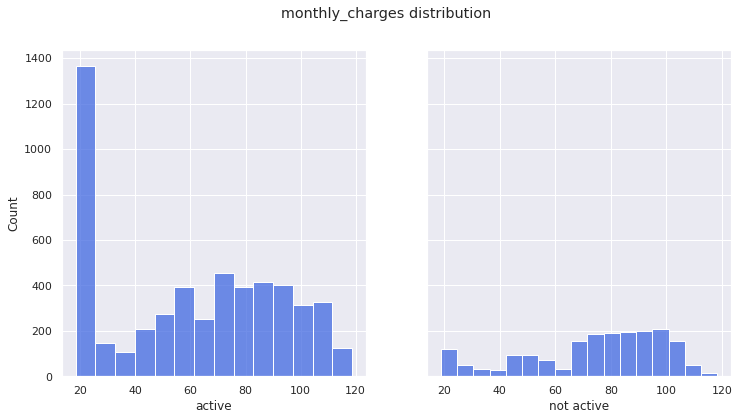

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

sns.histplot(x=active['monthly_charges'], ax=ax1, color='royalblue')
sns.histplot(x=not_active['monthly_charges'], ax=ax2, color='royalblue')

ax1.set(xlabel='active')
ax2.set(xlabel='not active')

plt.suptitle('monthly_charges distribution')
plt.show()

In [83]:
data.groupby('is_active')['monthly_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
is_active,,,,,,,,
False,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35
True,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75


Среднее и медианное значение ежемесячных трат выше у клиентов, которые ушли в отток.

Теперь изучим поведение клиентов этих двух групп:

1. Сравним долю пользователей телефонной свзяи.
2. Сравним долю интернет-пользователей.

In [84]:
def calculate_frac(df):
  net_frac = len(df[df['multiple_lines'] == 'none']) 
  tel_frac = len(df[df['internet_service'] == 'none']) 
  tel_net_frac = len(df) - (net_frac + tel_frac)
  data = pd.DataFrame({'internet': [net_frac],
                   'telephony': [tel_frac],
                   'tel_and_net': [tel_net_frac]})
  return data

In [85]:
active_frac = calculate_frac(active)
not_active_frac = calculate_frac(not_active)

In [86]:
active_frac.index = ['active']
not_active_frac.index = ['not active']

In [87]:
df = pd.concat([active_frac.T, not_active_frac.T], axis=1)

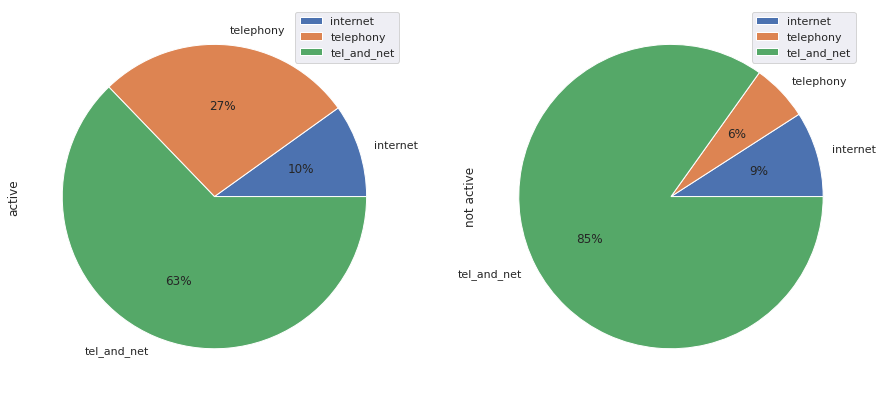

In [88]:
df.plot.pie(subplots=True, figsize=(15,15), autopct='%1.0f%%')
plt.show()

In [89]:
df

,active,not active
internet,512,170
telephony,1413,113
tel_and_net,3249,1586


Доля клиентов пользующихся только телефонией в первой группе в 4.5 раза больше, чем во второй.  

Доля клиентов пользующихся только интернетом в двух группах почти одинакова.

# **Preparation to modeling**

Для решения данной задачи попробуем 4 подхода:

1. Логистическая регрессия.
2. Случайный лес.
3. Градиентные бустинги.
4. Полносвязные нейронные сети.

Для подбора гиперпараметров будем использовать optuna.

Так как в таргете присутсвует дисбаланс - в качестве метрики возьмем AUC-ROC.

Для удоюства напишем функцию вывода графика AUC-ROC.

In [90]:
def plot_auc_roc(model, x, y):
  probs = model.predict_proba(x)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)

  plt.title('ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

Данные разделим на 3 части: 80% train, 10% valid, 10% test.

In [91]:
x = data.drop('is_active', axis=1)
y = data['is_active']

Данных не так много и присутсвует дисбаланс классов в таргете, поэтому разделять будем со стратификацией по таргету.

In [92]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, stratify=y, random_state=67)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.5, stratify=y_valid, random_state=67)

Закодируем категориальные признаки.

In [93]:
x_train_ohe = pd.get_dummies(x_train, drop_first=True)
x_valid_ohe = pd.get_dummies(x_valid, drop_first=True)
x_test_ohe = pd.get_dummies(x_test, drop_first=True)

In [94]:
cat_cols = data.select_dtypes(exclude=['number', 'bool']).columns

In [95]:
enc = OrdinalEncoder()

In [96]:
x_train[cat_cols] = enc.fit_transform(x_train[cat_cols])
x_valid[cat_cols] = enc.transform(x_valid[cat_cols])
x_test[cat_cols] = enc.transform(x_test[cat_cols])

In [97]:
x_train.shape , x_train_ohe.shape

((5634, 17), (5634, 28))

Приступим к машинному обучению.

# **Logistic regression**

In [98]:
model = LogisticRegression(max_iter=1000, random_state=67)

In [99]:
model.fit(x_train_ohe, y_train)

LogisticRegression(max_iter=1000, random_state=67)

In [100]:
roc_auc_score(y_valid, model.predict_proba(x_valid_ohe)[:, 1])

0.842313222106145

Очень неплохой результат для бейзлайна. Попробуем его улучшить, подобрав гиперпараметры.

In [101]:
log_reg_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

In [102]:
clf = GridSearchCV(model, log_reg_params)

In [103]:
clf.fit(x_train_ohe, y_train)
clf.best_params_

{'C': 100}

In [104]:
model = clf.best_estimator_

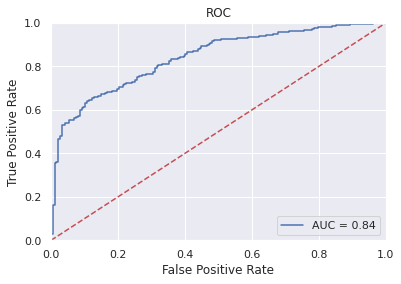

In [105]:
plot_auc_roc(model, x_valid_ohe, y_valid)

Логистическая регрессия прекрасно справилась, показав 0.84 AUC-ROC.

# **Random forest**